# Using OASIS for length of stay prediction

## Exercise 1:

Predict if the length of stay (LOS) of the ICU patients are "short" or "long" based on the severity score OASIS of the fisrt 24 hours (and 48 hours) of an ICU stay on MIMIC-III.


### Help for the exercise:

### OASIS

The Oxford Acute Severity of Illness Score (OASIS) consisted of age, elective surgery, prior length of stay (LOS) and seven physiologic measurements: Glasgow Coma Score (GCS), heart rate, mean arterial pressure (MAP), respiratory rate, temperature, urine output, ventilated.

For each variable, the worst score across the first day in ICU should be used to tabulate OASIS.

See [here](https://alistairewj.github.io/project/oasis/) for more information.

The concept elective surgery is where a patient is admitted to the intensive care unit either in routine preparation for a planned surgery or for stabilization after completion of a planned surgery. Elective surgery is an important covariate for many risk adjustments as patients who are admitted to the ICU for planned surgeries tend to be healthier than their counterparts.


### Instructions for the exercise

- We provide you the variables already computed and saved in csv files, except age, elective surgery, pre-LOS and temperature.

- In order to compute the age and pre-LOS and consult the elective surgery information you need to merge tables PATIENTS, ADMISSIONS and ICUSTAYS. 
    - You should compute the age at the time the patient is admitted to the ICU from date of birth (dob) from PATIENTS table, then you can drop dob from the dataframe. 
    - For the pre-LOS you should compare intime from ICUSTAYS table and admittime from ADMISSIONS table. 
    - The elective surgery information is stored in the column admission_type of PATIENTS, ADMISSIONS and ICUSTAYS table.

- You need CHARTEVENTS table to get the temperature (measures in Fahrenheit and Celsius) and D_ITEMS table to consult the itemid for the measure.
    - The variables can be duplicated, since they can come from Carevue or Metavision source systems of MIMIC-III, so you have to look for the different labels.
    - You can use pandas.DataFrame.loc to look for the itemid corresponding to labels of the temperature in D_ITEMS table. If you do not know the exact label you are looking for, you can look for the strings in column label containing 'Temperature' using pandas.Series.str.contains as follows:
    > df_ditems.loc[df_ditems.label.str.contains('Temperature', case=False, na=False, regex=False)]


- Once you have computed these variables you can read the rest of variables provided in the csv files and merge them into a single dataframe to pass it to the OASIS function (see [here](https://gist.github.com/tompollard/d4c216d0c4ad30481c99)) to compute the severity score.


- The Glasgow Coma Scale is stored in a different way in Metavision and Carevue. 
    - Metavision saves the three tests separately: GCS - Eye Opening,  GCS - Motor Response, GCS - Verbal Response
    - Carevue saves a single test: GCS_total.
    - We provide you 4 separate csv files with these information: GCS_E_metavision.csv, GCS_M_metavision.csv, GCS_V_metavision.csv and  GCS_total_carevue.csv
    - You should concatenate the values and keep the worst one which corresponds to the minimum score.


- Each csv file contains a dataframe with: [subject_id, hadm_id, icustay_id, variable_Time and variable value], except for the ventilation which just contains:  [subject_id, hadm_id, icustay_id, variable_Time], since the important information is if there is ventilation or not (YES or NO) and when has been installed. 


- Normalize the measures time. Use intime, which provides the date and time the patient was transferred into the ICU, as the reference value to compute the time that has passed since then until the variable measurement were taken.

- After the normalization, you can filter the instances to keep the ones of the first 24 hours (or 48 hours) as observations to compute the OASIS score. 
    - Try to different strategies:
        - All the instances of the first 24 hours.
        - All the instances of the first 48 hours.

- For the prediction, consider the following binary label:
    - LOS < 4: short stay
    - Otherwise: long stay.
    
- Use Random forest to classify using a 5-fold cross validation.

- As can be seen in the code to compute OASIS, the score is NaN if any of the considered variables has all its instances as NaN. MIMIC-III has many NaN values and the demo subset is more limited in the number. So, the number of samples with OASIS different of NaNs considering first 24h is just 8. You can use the first 48h but the number is also very limited and the performance of the proposed classifier will be very poor. 

- We suggest that you also try an alternative to compute the OASIS score. 
    - You can change the original code to consider the variable as 0.0 (state in normal range) when all instances of the variable are NaN. For that use np.nansum instead of using sum in the line:
        > oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp,oasis_temp, oasis_urine, oasis_vent, oasis_surg]). 
   
- Analyze the results of the three different alternatives (Original OASIS with 48h, Modification of OASIS with 24h and 48h):
    - Compare the mean accuracy
    - Build the confusion matrix



In [1]:
#needed libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold,cross_val_score, GridSearchCV,cross_val_predict
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

Download the MIMIC-III Clinical Database Demo can be download from [here](https://physionet.org/content/mimiciii-demo/1.4/) and copy the csv files in a 'data' folder.


In [2]:
path = "data/" #path to my data folder 

# Solution Exercise 1
<a id='ex1'></a>

## Download data and select columns
First of all, we need to compute the following varaibles : age, elective surgery and pre-LOS. In order to do this, let us download some data and start working with them.

In [3]:
# Download data, PATIENTS, ADMISSIONS and ICUSTAYS
df_patients = pd.read_csv(path+ 'PATIENTS.csv')
df_admissions = pd.read_csv(path+ 'ADMISSIONS.csv')
df_icustays = pd.read_csv(path+ 'ICUSTAYS.csv')

In [4]:
# Select columns
df_patients = df_patients[['subject_id','dob']]
df_admissions = df_admissions[['subject_id','hadm_id','admittime','admission_type']]
df_icustays = df_icustays[['subject_id','hadm_id','icustay_id','intime','los']]

## Merge data
Once we have the data, let us merge the dataframes.

In [5]:
# Merge and visualize data
df1 = pd.merge(df_patients, df_admissions,how='left',on=['subject_id'])
df_admissions = pd.merge(df1,df_icustays,how='left', on=['subject_id','hadm_id'])
df_admissions.head()

,subject_id,dob,hadm_id,admittime,admission_type,icustay_id,intime,los
0,10006,2094-03-05 00:00:00,142345,2164-10-23 21:09:00,EMERGENCY,206504,2164-10-23 21:10:15,1.6325
1,10011,2090-06-05 00:00:00,105331,2126-08-14 22:32:00,EMERGENCY,232110,2126-08-14 22:34:00,13.8507
2,10013,2038-09-03 00:00:00,165520,2125-10-04 23:36:00,EMERGENCY,264446,2125-10-04 23:38:00,2.6499
3,10017,2075-09-21 00:00:00,199207,2149-05-26 17:19:00,EMERGENCY,204881,2149-05-29 18:52:29,2.1436
4,10019,2114-06-20 00:00:00,177759,2163-05-14 20:43:00,EMERGENCY,228977,2163-05-14 20:43:56,1.2938


## Age, Pre-LOS and Elective Surgery
Let us compute the age of each patient. We will use the 'dob' column. Notice that, for privacy reasons, the data in 'dob' is shifted. We can obtain the age doing some computations. Later on, we will get the pre-LOS, in which we should compare 'intime' from ICUSTAYS table and 'admittime' from ADMISSIONS table. Finally, we will see that the elective surgery information is stored in the column 'admission_type', we will check it later.

In [6]:
# Compute Age and add it to the dataframe
# We are not allowed to acces the true date of birth. Is shifted.
'''
This date shift is consistent across all times for the patient, 
allowing us to calculate their age as the time of their ICU admission minus their date of birth
'''

df_admissions['age'] = pd.to_datetime(df_admissions['intime']).dt.year - pd.to_datetime(df_admissions['dob']).dt.year
df_admissions.loc[df_admissions['age']>=300,"age"]=90 #Set at 90 people over 89 years of age
df_admissions = df_admissions.drop(['dob'],axis=1)
df_admissions.head()

,subject_id,hadm_id,admittime,admission_type,icustay_id,intime,los,age
0,10006,142345,2164-10-23 21:09:00,EMERGENCY,206504,2164-10-23 21:10:15,1.6325,70
1,10011,105331,2126-08-14 22:32:00,EMERGENCY,232110,2126-08-14 22:34:00,13.8507,36
2,10013,165520,2125-10-04 23:36:00,EMERGENCY,264446,2125-10-04 23:38:00,2.6499,87
3,10017,199207,2149-05-26 17:19:00,EMERGENCY,204881,2149-05-29 18:52:29,2.1436,74
4,10019,177759,2163-05-14 20:43:00,EMERGENCY,228977,2163-05-14 20:43:56,1.2938,49


In [7]:
# Compute pre-LOS and add it to the dataframe
preLOS = pd.to_datetime(df_admissions['intime']) - pd.to_datetime(df_admissions['admittime'])
# Convert it into hours
preLOS = preLOS.dt.total_seconds()/3600
df_admissions['prelos'] = preLOS
df_admissions.head()

,subject_id,hadm_id,admittime,admission_type,icustay_id,intime,los,age,prelos
0,10006,142345,2164-10-23 21:09:00,EMERGENCY,206504,2164-10-23 21:10:15,1.6325,70,0.020833
1,10011,105331,2126-08-14 22:32:00,EMERGENCY,232110,2126-08-14 22:34:00,13.8507,36,0.033333
2,10013,165520,2125-10-04 23:36:00,EMERGENCY,264446,2125-10-04 23:38:00,2.6499,87,0.033333
3,10017,199207,2149-05-26 17:19:00,EMERGENCY,204881,2149-05-29 18:52:29,2.1436,74,73.558056
4,10019,177759,2163-05-14 20:43:00,EMERGENCY,228977,2163-05-14 20:43:56,1.2938,49,0.015556


In [8]:
# Let us check the values we have in the admission type feature
print(df_admissions['admission_type'].unique())

['EMERGENCY' 'ELECTIVE' 'URGENT']


# Rest of the variables
We need the following variables to compute OASIS:
+ prelos
+ age
+ admission_type
+ temperature
+ GCS_total
+ hrate
+ MAP
+ resp_rate
+ urine
+ ventilated

We have alredy computed the first three. Let us compute the rest.

## Temperature
We need CHARTEVENTS table to get the temperature (measures in Fahrenheit and Celsius) and D_ITEMS table to consult the itemid for the measure. Therefore, let us download and merge this data.

In [9]:
df_chartevents = pd.read_csv(path+ 'CHARTEVENTS.csv')
df_items = pd.read_csv(path+ 'D_ITEMS.csv')

In [10]:
# Select columns
df_chartevents = df_chartevents[['subject_id','hadm_id','icustay_id','itemid','charttime','value','valuenum','valueuom']]
df_items = df_items[['itemid','label','dbsource','unitname']]

In [11]:
# Merge
df_chit = pd.merge(df_chartevents,df_items,how='left',on=['itemid'])
df_chit.head()

,subject_id,hadm_id,icustay_id,itemid,charttime,value,valuenum,valueuom,label,dbsource,unitname
0,40124,126179,279554.0,223761,2130-02-04 04:00:00,95.9,95.9,?F,Temperature Fahrenheit,metavision,?F
1,40124,126179,279554.0,224695,2130-02-04 04:25:00,2222221.7,2222221.7,cmH2O,Peak Insp. Pressure,metavision,cmH2O
2,40124,126179,279554.0,220210,2130-02-04 04:30:00,15.0,15.0,insp/min,Respiratory Rate,metavision,insp/min
3,40124,126179,279554.0,220045,2130-02-04 04:32:00,94.0,94.0,bpm,Heart Rate,metavision,bpm
4,40124,126179,279554.0,220179,2130-02-04 04:32:00,163.0,163.0,mmHg,Non Invasive Blood Pressure systolic,metavision,mmHg


Let us look for the item we are interested in, in this case, temperature. The variables can be duplicated, since they can come from Carevue or Metavision source systems of MIMIC-III, so we have to look for the different labels. Let us look for the variable we are searching, something containing the word temperature. Let us search it!!

In [12]:
df_items.loc[df_items.label.str.contains('Temperature', case=False, na=False, regex=False)]

,itemid,label,dbsource,unitname
547,591,RLE [Temperature],carevue,NaN
553,597,RUE [Temperature],carevue,NaN
597,645,Skin [Temperature],carevue,NaN
626,676,Temperature C,carevue,NaN
627,677,Temperature C (calc),carevue,NaN
628,678,Temperature F,carevue,NaN
629,679,Temperature F (calc),carevue,NaN
5006,8537,"Temp/Iso/Warmer [Temperature, degrees C]",carevue,NaN
9569,223761,Temperature Fahrenheit,metavision,?F
9570,223762,Temperature Celsius,metavision,?C


We are interested in the following variables: 
+ Temperature C, Temperature C (calc), Temperature F, Temperature F (calc) **(carevue source)**
+ Temperature Fahrenheit, Temperature Celsius **(metavision source)**

We will build a function to find the measured values (filtering on time,either 24h or 48h) of temperature for each patient. Moreover, we will homogenize all units to Celsius. The function will return a dataframe with 'subject_id', 'icustay_id' and the values of the temperatures in Celsius.

In [13]:
def temp(time, df, df_ch):
    
    # Get the items we are intested in(temperature)
    df_temp = df_ch[df_ch.label.str.contains('^Temperature', case=False, na=False, regex=True)]
    df_temp = df_temp.drop(df_temp.index[df_temp['label']=='Temperature Site'])
    # Compute the temperature in Celsius and add a column to the dataframe
    list_temp = []
    for i in range(df_temp.shape[0]):
        char = df_temp["valueuom"].values[i]
        val = df_temp["valuenum"].values[i]
        if type(char)== str:
            if 'F' in char:
                list_temp.append((5/9)*(val-32))
            else:
                list_temp.append(val)
        else:
            list_temp.append(np.nan)
    
    df_temp['temp_c'] = list_temp
    
    # Merge dataframes
    dff = pd.merge(df,df_temp,how='left',on=['subject_id','hadm_id','icustay_id'])
    
    # Compute the hours between time observation made and patient went to ICU and filter
    hours = pd.to_datetime(dff['charttime']) - pd.to_datetime(dff['intime'])
    dff['hours'] = hours.dt.total_seconds()/3600
    df_filter = dff[(dff['hours']<=time) & (dff['hours']>0)]
    
    return df_filter[['subject_id','icustay_id','temp_c']]

## Glasgow Coma Scale
The Glasgow Coma Scale is stored in a different way in Metavision and Carevue.
+ Metavision saves the three tests separately: GCS - Eye Opening, GCS - Motor Response, GCS - Verbal Response
+ Carevue saves a single test: GCS_total

We have been provided 4 separate csv files with these information: GCS_E_metavision.csv, GCS_M_metavision.csv, GCS_V_metavision.csv and GCS_total_carevue.csv. We should concatenate all the values.


In [14]:
# Download the data and rename columns for computations
df_GCS_E_metavision = pd.read_csv(path+ 'variables/GCS_E_metavision.csv',index_col=0)
df_GCS_E_metavision = df_GCS_E_metavision.rename(columns={'GCS_E_Time': 'Time'})
df_GCS_M_metavision = pd.read_csv(path+ 'variables/GCS_M_metavision.csv',index_col=0)
df_GCS_M_metavision = df_GCS_M_metavision.rename(columns={'GCS_M_Time': 'Time'})
df_GCS_V_metavision = pd.read_csv(path+ 'variables/GCS_V_metavision.csv',index_col=0)
df_GCS_V_metavision = df_GCS_V_metavision.rename(columns={'GCS_V_Time': 'Time'})
df_GCS_total_carevue = pd.read_csv(path+ 'variables/GCS_total_carevue.csv',index_col=0)
df_GCS_total_carevue = df_GCS_total_carevue.rename(columns={'GCS_total_Carevue_Time': 'Time','GCS_total_Carevue': 'GCS_total'})

In [15]:
# Merge the metavision source and compute the GCS_total feature
df1 = pd.merge(df_GCS_E_metavision,df_GCS_M_metavision,how='left',on=['subject_id','hadm_id','icustay_id','Time'])
df_GCS_total_metavision = pd.merge(df1,df_GCS_V_metavision,how='left',on=['subject_id','hadm_id','icustay_id','Time'])
df_GCS_total_metavision['GCS_total'] = df_GCS_total_metavision['GCS_E']+df_GCS_total_metavision['GCS_M']+df_GCS_total_metavision['GCS_V']
df_GCS_total_metavision = df_GCS_total_metavision.drop(['GCS_E','GCS_M','GCS_V'],axis=1)

In [16]:
# Visualization, choose one of them
df_GCS_total_metavision.head()
#df_GCS_total_carevue.head()

,subject_id,hadm_id,icustay_id,Time,GCS_total
0,40124,126179,279554.0,2130-02-04 04:00:00,8.0
1,40124,126179,279554.0,2130-02-04 08:00:00,10.0
2,40124,126179,279554.0,2130-02-04 12:00:00,14.0
3,40124,126179,279554.0,2130-02-04 16:00:00,14.0
4,40124,126179,279554.0,2130-02-04 20:13:00,14.0


We should concatenate this two final dataframes. Firstly, let us build a generic function that filters on time. This function will be useful in future steps also. We will concatenate and filter later.

In [17]:
def filter_time(period,df1,df2,measured_time,var_name):#df1 should be df_admissions
    
    # Merge the admissions and the other dataframe
    df = pd.merge(df1,df2,how='left',on=['subject_id','hadm_id','icustay_id'])
    # Compute the hours between time observation made and patient went to ICU and filter
    hours = pd.to_datetime(df[measured_time]) - pd.to_datetime(df['intime'])
    df['hours'] = hours.dt.total_seconds()/3600
    df_filter = df[(df['hours']<=period) & (df['hours']>0)]
    
    return df_filter[['subject_id','icustay_id',var_name]]
    

## Heart rate, MAP, Respiratory rate
Let us continue with these variables. First, let us download the data and later on, we will filter on time.

In [18]:
# Download data
df_Hrate = pd.read_csv(path+ 'variables/heartRate.csv',index_col=0)
df_map = pd.read_csv(path+ 'variables/MAP.csv',index_col=0)
df_resp = pd.read_csv(path+ 'variables/RespiratoryRate.csv',index_col=0)

## Urine
Let us continue with the Urine variable. First, let us download the data

In [19]:
# Download data
df_ur = pd.read_csv(path+ 'variables/urine.csv',index_col=0)

**CAUTION**: For the urine variable we need the total urine output over the period of time we are interested in. Let us compute the sum of 'urine' for every 'icustay_id' in the period of time we are interested in (either 24 or 48h). We will return a dataframe with the value for every 'icustay_id'.

In [20]:
def urine(time, df,df_u):
    # Merge the admissions and the hrate dataframes
    df = pd.merge(df,df_u,how='left',on=['subject_id','hadm_id','icustay_id'])
    
    # Compute the hours between time observation made and patient went to ICU and filter
    hours = pd.to_datetime(df['urine_Time']) - pd.to_datetime(df['intime'])
    df['hours'] = hours.dt.total_seconds()/3600
    df_filter = df[(df['hours']<=time) & (df['hours']>0)]
    
    # Compute the sum for each icustay_id
    df_res = pd.DataFrame()
    for icu_id in df_filter['icustay_id'].unique():
        df_urine = df_filter[df_filter['icustay_id']==icu_id]
        df_res = pd.concat([df_res,pd.DataFrame({'subject_id':df_urine['subject_id'].unique(),'icustay_id':[icu_id],'urine':[df_urine['urine'].sum()]})])

    return df_res

## Ventilation
Let us finish with the ventilated variable. First, let us download the data. Later on, we will need to add a column setting 'y' or 'n' if the patient ventilated or not respectively. Let us implement this. We will return a dataframe with the desire information for every 'icustay_id'.

In [21]:
# Download the data
df_ventilated = pd.read_csv(path+ 'variables/ventilation.csv',index_col=0)

In [22]:
# Adding y or n
df_ventilated['ventilated'] = 'y'
# Merge dataframe to include the 'n'
df_ventilated = pd.merge(df_admissions,df_ventilated,how='left',on=['subject_id','hadm_id','icustay_id'])
df_ventilated['ventilated'] = df_ventilated['ventilated'].fillna('n')
# Dropping unneeded features
df_ventilated = df_ventilated[['subject_id','icustay_id','ventilated']]
df_ventilated = df_ventilated.drop_duplicates()
df_ventilated.head()

,subject_id,icustay_id,ventilated
0,10006,206504,n
1,10011,232110,n
2,10013,264446,n
3,10017,204881,n
4,10019,228977,n


## Compute OASIS
At this point, we are able to compute OASIS. We are going to modify the given function, compute_oasis, in order to allow NaN values in the computation. We are going to change the original code to consider the variable as 0.0 (state in normal range) when all instances of the variable are NaN.

In [23]:
# The MIT License

# Copyright (c) 2015 Tom Pollard

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

def compute_oasis(pd_dataframe, variableNAN = False):
    """
    Takes Pandas DataFrame as an argument and computes Oxford Acute 
    Severity of Illness Score (OASIS) (http://oasisicu.com/)
    
    The DataFrame should include only measurements taken over the first 24h 
    from admission. pd_dataframe should contain the following columns:
    
    'prelos' => Pre-ICU length of stay, hours
    'age' => Age of patient, years
    'GCS_total' => Total Glasgow Coma Scale for patient
    'hrate' => All heart rate measurements
    'MAP' => All mean arterial blood pressure measurements
    'resp_rate' => All respiratory rate measurements
    'temp_c' => All temperature measurements, C
    'urine' => Total urine output over 24 h (note, not consecutive measurements)
    'ventilated' => Is patient ventilated? (y,n)
    'admission_type' => Type of admission (elective, urgent, emergency) 
    
    Reference:
    Johnson AE, Kramer AA, Clifford GD. A new severity of illness scale 
    using a subset of Acute Physiology And Chronic Health Evaluation 
    data elements shows comparable predictive accuracy.
    Crit Care Med. 2013 Jul;41(7):1711-8. doi: 10.1097/CCM.0b013e31828a24fe
    http://www.ncbi.nlm.nih.gov/pubmed/23660729
    """
    
    # 10 variables
    oasis_score, oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg = 0,0,0,0,0,0,0,0,0,0,0   
    # Pre-ICU length of stay, hours
    for val in pd_dataframe['prelos']:
        if val >= 4.95 and val <= 24.0:
            oasis_prelos = np.nanmax([0,oasis_prelos])
        elif val > 311.8:
            oasis_prelos = np.nanmax([1,oasis_prelos])
        elif val > 24.0 and val <= 311.8:
            oasis_prelos = np.nanmax([2,oasis_prelos])
        elif val >= 0.17 and val < 4.95:
            oasis_prelos = np.nanmax([3,oasis_prelos])
        elif val < 0.17:
            oasis_prelos = np.nanmax([5,oasis_prelos])
        else:
            oasis_prelos = np.nanmax([np.nan,oasis_prelos])  
    if pd_dataframe['prelos'].isnull().all():
        oasis_prelos = np.nan 
    # Age, years
    for val in pd_dataframe['age']:
        if val < 24:
            oasis_age = np.nanmax([0,oasis_age])
        elif val >= 24 and val <= 53:
            oasis_age = np.nanmax([3,oasis_age])
        elif val > 53 and val <= 77:
            oasis_age = np.nanmax([6,oasis_age])
        elif val > 77 and val <= 89:
            oasis_age = np.nanmax([9,oasis_age])
        elif val > 89:
            oasis_age = np.nanmax([7,oasis_age])
        else:
            oasis_age = np.nanmax([np.nan,oasis_age])
    if pd_dataframe['age'].isnull().all():
        oasis_age = np.nan 
    # Glasgow Coma Scale
    for val in pd_dataframe['GCS_total']:
        if val == 15:
            oasis_gcs = np.nanmax([0,oasis_gcs])
        elif val == 14:
            oasis_gcs = np.nanmax([3,oasis_gcs])
        elif val >= 8 and val <= 13:
            oasis_gcs = np.nanmax([4,oasis_gcs])
        elif val >= 3 and val <= 7:
            oasis_gcs = np.nanmax([10,oasis_gcs])
        else:
            oasis_gcs = np.nanmax([np.nan,oasis_gcs])
    if pd_dataframe['GCS_total'].isnull().all():
        oasis_gcs = np.nan     
    # Heart rate
    for val in pd_dataframe['hrate']:
        if val >= 33 and val <= 88:
            oasis_hr = np.nanmax([0,oasis_hr])
        elif val > 88 and val <= 106:
            oasis_hr = np.nanmax([1,oasis_hr])
        elif val > 106 and val <= 125:
            oasis_hr = np.nanmax([3,oasis_hr])
        elif val < 33:
            oasis_hr = np.nanmax([4,oasis_hr])
        elif val > 125:
            oasis_hr = np.nanmax([6,oasis_hr])
        else:
            oasis_hr = np.nanmax([np.nan,oasis_hr])
    if pd_dataframe['hrate'].isnull().all():
        oasis_hr = np.nan 
    # Mean arterial pressure
    for val in pd_dataframe['MAP']:
        if val >=61.33 and val <= 143.44:
            oasis_map = np.nanmax([0,oasis_map])
        elif val >= 51.0 and val < 61.33:
            oasis_map = np.nanmax([2,oasis_map])
        elif (val >= 20.65 and val < 51.0) or (val > 143.44):
            oasis_map = np.nanmax([3,oasis_map])
        elif val < 20.65:
            oasis_map = np.nanmax([4,oasis_map])
        else:
            oasis_map = np.nanmax([np.nan,oasis_map])
    if pd_dataframe['MAP'].isnull().all():
        oasis_map = np.nan 
    # Respiratory Rate
    for val in pd_dataframe['resp_rate']:
        if val >=13 and val <= 22:
            oasis_resp = np.nanmax([0,oasis_resp])
        elif (val >= 6 and val <= 12) or (val >= 23 and val <= 30):
            oasis_resp = np.nanmax([1,oasis_resp])
        elif val > 30 and val <= 44:
            oasis_resp = np.nanmax([6,oasis_resp])
        elif val > 44:
            oasis_resp = np.nanmax([9,oasis_resp])
        elif val < 6:
            oasis_resp = np.nanmax([10,oasis_resp])
        else:
            oasis_resp = np.nanmax([np.nan,oasis_resp])
    if pd_dataframe['resp_rate'].isnull().all():
        oasis_resp = np.nan 
    # Temperature, C
    for val in pd_dataframe['temp_c']:
        if val >= 36.40 and val <= 36.88:
            oasis_temp = np.nanmax([0,oasis_temp])
        elif (val >= 35.94 and val < 36.40) or (val > 36.88 and val <= 39.88):
            oasis_temp = np.nanmax([2,oasis_temp])
        elif val < 33.22:
            oasis_temp = np.nanmax([3,oasis_temp])            
        elif val >= 33.22 and val < 35.94:
            oasis_temp = np.nanmax([4,oasis_temp])
        elif val > 39.88:
            oasis_temp = np.nanmax([6,oasis_temp])
        else:
            oasis_temp = np.nanmax([np.nan,oasis_temp])
    if pd_dataframe['temp_c'].isnull().all():
        oasis_temp = np.nan 
    # Urine output, cc/day (total over 24h)
    val = np.max(pd_dataframe['urine'])
    if val >=2544.0 and val <= 6896.0:
        oasis_urine = np.nanmax([0,oasis_urine])
    elif val >= 1427.0 and val < 2544.0:
        oasis_urine = np.nanmax([1,oasis_urine])
    elif val >= 671.0 and val < 1427.0:
        oasis_urine = np.nanmax([5,oasis_urine])
    elif val > 6896.0:
        oasis_urine = np.nanmax([8,oasis_urine])
    elif val < 671:
        oasis_urine = np.nanmax([10,oasis_urine])
    else:
        oasis_urine = np.nanmax([np.nan,oasis_urine])
    if pd_dataframe['urine'].isnull().all():
        oasis_urine = np.nan 
    # Ventilated y/n
    for val in pd_dataframe['ventilated']:
        if val == 'n':
            oasis_vent = np.nanmax([0,oasis_vent])
        elif val == 'y':
            oasis_vent = np.nanmax([9,oasis_vent])
        else:
            oasis_vent = np.nanmax([np.nan,oasis_vent])
    if pd_dataframe['ventilated'].isnull().all():
        oasis_vent = np.nan 
    # Elective surgery y/n
    for val in pd_dataframe['admission_type']:
        if val == 'elective':
            oasis_surg = np.nanmax([0,oasis_surg])
        elif val in ['urgent','emergency']:
            oasis_surg = np.nanmax([6,oasis_surg])
        else:
            oasis_surg = np.nanmax([np.nan,oasis_surg])
    if pd_dataframe['admission_type'].isnull().all():
        oasis_surg = np.nan 
    # Return sum
    if variableNAN:
        oasis_score = np.nansum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
            oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    else:
        oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
            oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    return oasis_score

We will be working on two different frameworks. In the first one, we will work with 24h filtrated data and we will compute the OASIS using our modificated code. Finally, we will work with the 48h filtrated data and we will compute the OASIS, using both, the original and the modificated function

## Filtering in 24h
Let us get the filtered data for each variable and later on, we will build a dataframe with all the instances of the variables for each 'icustay_id', in which we will apply the OASIS function to get the OASIS for every 'icustay_id.

In [24]:
# Get the data for each variable
# Filtering in 24h
df_temperature = temp(24,df_admissions,df_chit)
df_meta = filter_time(24,df_admissions,df_GCS_total_metavision,'Time','GCS_total')
df_care = filter_time(24,df_admissions,df_GCS_total_carevue,'Time','GCS_total')
df_GCS = pd.concat([df_meta,df_care])
df_hrate = filter_time(24,df_admissions,df_Hrate,'hrate_Time','hrate')
df_MAP = filter_time(24,df_admissions,df_map,'MAP_Time','MAP')
df_resp_rate = filter_time(24,df_admissions,df_resp,'resp_rate_Time','resp_rate')
df_urine = urine(24,df_admissions,df_ur)
# ventilation also

In [25]:
df_oasis_24 = pd.DataFrame()
# for every icustay_id, get the dataframe with all the instances and compute oasis
for idx in df_admissions.icustay_id.unique():
    # Get all the instances
    df1 = pd.merge(df_admissions[df_admissions['icustay_id']==idx],df_temperature[df_temperature['icustay_id']==idx],how='left')
    df1 = df1.drop(['hadm_id','admittime','intime','subject_id','icustay_id'],axis=1)
    df2 = pd.concat([df1,df_GCS[df_GCS['icustay_id']==idx].reset_index()],axis=1)
    df3 = pd.concat([df2,df_hrate[df_hrate['icustay_id']==idx].reset_index()],axis=1)
    df4 = pd.concat([df3,df_MAP[df_MAP['icustay_id']==idx].reset_index()],axis=1)
    df5 = pd.concat([df4,df_resp_rate[df_resp_rate['icustay_id']==idx].reset_index()],axis=1)
    df6 = pd.concat([df5,df_urine[df_urine['icustay_id']==idx].reset_index()],axis=1)
    df7 = pd.concat([df6,df_ventilated[df_ventilated['icustay_id']==idx].reset_index()],axis=1)
    df7 = df7.drop(['subject_id','icustay_id','index'],axis=1)
    # Get the los
    non_null_los = df7['los'].notnull()
    non_null_los_values = df7['los'][non_null_los]
    value = float(non_null_los_values.unique())
    # Concatenate to obtain a unique dataframe
    df_oasis_24 = pd.concat([df_oasis_24,
                             pd.DataFrame({'icustay_id':[idx],'oasis':[compute_oasis(df7,variableNAN=True)],'los':value})])

Once this dataframe is built, make the binary classification in the 'los' variable.

In [26]:
# Binary label for the prediction
df_oasis_24['los'] = np.where(df_oasis_24['los']<4, 0, 1)#0 for short, 1 for long
df_oasis_24 # OASIS and los for every icustay_id

,icustay_id,oasis,los
0,206504,33.0,0
0,232110,18.0,1
0,264446,30.0,0
0,204881,22.0,0
0,228977,41.0,0
...,...,...,...
0,286428,12.0,0
0,217724,52.0,0
0,239396,56.0,1
0,238186,25.0,0


## Filtering in 48h
Let us get the filtered data for each variable and later on, we will build a dataframe with all the instances of the variables for each 'icustay_id', in which we will will apply the OASIS function to get the OASIS for every 'icustay_id.

In [27]:
# Get the data for each variable
# Filtering in 48h
df_temperature = temp(48,df_admissions,df_chit)
df_meta = filter_time(48,df_admissions,df_GCS_total_metavision,'Time','GCS_total')
df_care = filter_time(48,df_admissions,df_GCS_total_carevue,'Time','GCS_total')
df_GCS = pd.concat([df_meta,df_care])
df_hrate = filter_time(48,df_admissions,df_Hrate,'hrate_Time','hrate')
df_MAP = filter_time(48,df_admissions,df_map,'MAP_Time','MAP')
df_resp_rate = filter_time(48,df_admissions,df_resp,'resp_rate_Time','resp_rate')
df_urine = urine(48,df_admissions,df_ur)
#ventilation also

Now, we are going to build two dataframes, one in which we use the original OASIS function, and one in which we use the modification of the OASIS function. Let us start with the one that uses the original OASIS function.

In [28]:
# Dataframe using the original OASIS function
df_oasis_48_nan = pd.DataFrame()
# For every icustay_id, get the dataframe with all the instances and compute oasis
for idx in df_admissions.icustay_id.unique():
    # Get all the instances
    df1 = pd.merge(df_admissions[df_admissions['icustay_id']==idx],df_temperature[df_temperature['icustay_id']==idx],how='left')
    df1 = df1.drop(['hadm_id','admittime','intime','subject_id','icustay_id'],axis=1)
    df2 = pd.concat([df1,df_GCS[df_GCS['icustay_id']==idx].reset_index()],axis=1)
    df3 = pd.concat([df2,df_hrate[df_hrate['icustay_id']==idx].reset_index()],axis=1)
    df4 = pd.concat([df3,df_MAP[df_MAP['icustay_id']==idx].reset_index()],axis=1)
    df5 = pd.concat([df4,df_resp_rate[df_resp_rate['icustay_id']==idx].reset_index()],axis=1)
    df6 = pd.concat([df5,df_urine[df_urine['icustay_id']==idx].reset_index()],axis=1)
    df7 = pd.concat([df6,df_ventilated[df_ventilated['icustay_id']==idx].reset_index()],axis=1)
    df7 = df7.drop(['subject_id','icustay_id','index'],axis=1)
    
    # Get the los
    non_null_los = df7['los'].notnull()
    non_null_los_values = df7['los'][non_null_los]
    value = float(non_null_los_values.unique())
    # Concatenate to obtain a unique dataframe
    df_oasis_48_nan = pd.concat([df_oasis_48_nan,
                             pd.DataFrame({'icustay_id':[idx],'oasis':[compute_oasis(df7,variableNAN=False)],'los':value})])

Once this dataframe is built, make the binary classification in the 'los' variable.

In [29]:
# Binary label for the prediction
df_oasis_48_nan['los'] = np.where(df_oasis_48_nan['los']<4, 0, 1)#0 for short, 1 for long
df_oasis_48_nan # OASIS and los for every icustay_id

,icustay_id,oasis,los
0,206504,NaN,0
0,232110,NaN,1
0,264446,33.0,0
0,204881,NaN,0
0,228977,45.0,0
...,...,...,...
0,286428,27.0,0
0,217724,52.0,0
0,239396,56.0,1
0,238186,NaN,0


In [30]:
# Dataframe using the modificated OASIS function
df_oasis_48 = pd.DataFrame()
# For every icustay_id, get the dataframe with all the instances and compute oasis
for idx in df_admissions.icustay_id.unique():
    # Get all the instances
    df1 = pd.merge(df_admissions[df_admissions['icustay_id']==idx],df_temperature[df_temperature['icustay_id']==idx],how='left')
    df1 = df1.drop(['hadm_id','admittime','intime','subject_id','icustay_id'],axis=1)
    df2 = pd.concat([df1,df_GCS[df_GCS['icustay_id']==idx].reset_index()],axis=1)
    df3 = pd.concat([df2,df_hrate[df_hrate['icustay_id']==idx].reset_index()],axis=1)
    df4 = pd.concat([df3,df_MAP[df_MAP['icustay_id']==idx].reset_index()],axis=1)
    df5 = pd.concat([df4,df_resp_rate[df_resp_rate['icustay_id']==idx].reset_index()],axis=1)
    df6 = pd.concat([df5,df_urine[df_urine['icustay_id']==idx].reset_index()],axis=1)
    df7 = pd.concat([df6,df_ventilated[df_ventilated['icustay_id']==idx].reset_index()],axis=1)
    df7 = df7.drop(['subject_id','icustay_id','index'],axis=1)
    
    # Get the los
    non_null_los = df7['los'].notnull()
    non_null_los_values = df7['los'][non_null_los]
    value = float(non_null_los_values.unique())
    # Concatenate to obtain a unique dataframe
    df_oasis_48 = pd.concat([df_oasis_48,
                             pd.DataFrame({'icustay_id':[idx],'oasis':[compute_oasis(df7,variableNAN=True)],'los':value})])

Once this dataframe is built, make the binary classification in the 'los' variable.

In [31]:
# Binary label for the prediction
df_oasis_48['los'] = np.where(df_oasis_48['los']<4, 0, 1)#0 for short, 1 for long
df_oasis_48 # OASIS and los for every icustay_id

,icustay_id,oasis,los
0,206504,33.0,0
0,232110,24.0,1
0,264446,33.0,0
0,204881,30.0,0
0,228977,45.0,0
...,...,...,...
0,286428,27.0,0
0,217724,52.0,0
0,239396,56.0,1
0,238186,25.0,0


We have the three dataframes we were interested in. In the first one, we have computed OASIS, using instances of the first 24h, using the modification of the OASIS function. Then, the other two, are computed using instances of the first 48h, using the original OASIS function and the modification of the OASIS function respectively.

## Training and predicting
Let us use train a model, and see its performance.We will use Random forest to classify using a 5-fold cross validation.

In [32]:
def train(df):
    
    # Get the data, drop NaN if necessary, and prepare the prediction array
    df = df.drop(['icustay_id'],axis=1)
    X = df.dropna().iloc[:,0].values
    y = df.dropna().iloc[:,1].values
    yhat = np.zeros((y.shape[0]))
    # 5-fold cross validation
    skf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
    # Model
    clf = RandomForestClassifier(random_state=0)
    for train_idx, test_idx in skf.split(X,y):
        X_train,y_train = X[train_idx],y[train_idx]
        X_test,y_test = X[test_idx],y[test_idx]
        clf.fit(X_train.reshape(-1,1),y_train)
        yhat[test_idx] = clf.predict(X_test.reshape(-1,1))
    
    #print('Accuracy of the model:',accuracy_score(y,yhat))
    print('Mean accuracy of the model:',cross_val_score(clf,X.reshape(-1,1),y,cv=5).mean())
    print('Confusion matrix:\n')
    disp = ConfusionMatrixDisplay(confusion_matrix(y,yhat))
    disp.plot()
    plt.show()

Let us analyze the results of the three different alternatives by comparing the mean accuracy and building the confusion matrix.

Model using the modification of OASIS (allowing NaNs) with 24 hours:
Mean accuracy of the model: 0.6179894179894181
Confusion matrix:



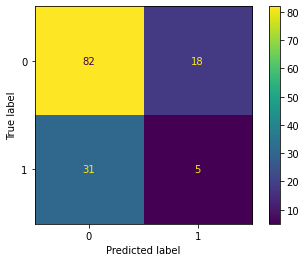




Model using the original OASIS with 48 hours:
Mean accuracy of the model: 0.39090909090909093
Confusion matrix:



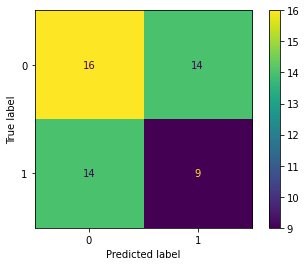




Model using the modification of OASIS (allowing NaNs) with 48 hours:
Mean accuracy of the model: 0.6248677248677249
Confusion matrix:



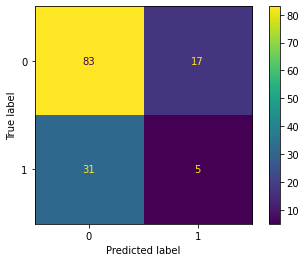

In [33]:
print('Model using the modification of OASIS (allowing NaNs) with 24 hours:')
train(df_oasis_24)
print('\n\n')
print('Model using the original OASIS with 48 hours:')
train(df_oasis_48_nan)
print('\n\n')
print('Model using the modification of OASIS (allowing NaNs) with 48 hours:')
train(df_oasis_48)
print('\n\n')

We will analyze the results at the final of this notebook. I would just like to point out the poor perfromance of the model using the original OASIS function, this is because we have too many NaN's for the classiffier to work properly.

## Exercise 2:
<a id='ex2'></a>
I) Compute:

    - the number of different patients in the dataset 
    
    - the number of different hospital admissions in the dataset 
    
    - the number of different icu stays in the dataset 
    
II) Show that we can have a patient with more than one icustay.

III) Revise the number of ICU admissions registered by the two different systems: Metavision and Carevue.

IV) Compute the number of NaN OASIS values for your different implementations.

Let us solve this exercise.

# Solution Exercise 2

In [34]:
#Exercise I
print('EXERCISE I\n\n')
print('The number of different patients in the dataset is:',df_admissions['subject_id'].nunique())
print('The number of different hospital admissions in the dataset is:', df_admissions['hadm_id'].nunique())
print('The number of different icu stays in the dataset is:', df_admissions['icustay_id'].nunique())
print('\n\n')

EXERCISE I


The number of different patients in the dataset is: 100
The number of different hospital admissions in the dataset is: 129
The number of different icu stays in the dataset is: 136





In [35]:
#Exercise II
print('EXERCISE II\n\n')
print('A patient can have more than one icustay, for example, the patient with subject_id=10119')
df_admissions[df_admissions['subject_id']==10119].drop(['admittime','admission_type','intime','age','prelos'],axis=1)

EXERCISE II


A patient can have more than one icustay, for example, the patient with subject_id=10119


,subject_id,hadm_id,icustay_id,los
48,10119,157466,247686,7.902
49,10119,165436,205589,1.892


In [36]:
#Exercise III
#Let us reload the dataset
df_icustays = pd.read_csv(path+ 'ICUSTAYS.csv')
print('EXERCISE III\n\n')
print('Revision of the number of ICU admissions registered by the two different systems: Metavision and Carevue.')
print(df_icustays['dbsource'].value_counts())
print('\n\n')

EXERCISE III


Revision of the number of ICU admissions registered by the two different systems: Metavision and Carevue.
metavision    77
carevue       59
Name: dbsource, dtype: int64





In [37]:
#Exercise IV
print('EXERCISE IV\n\n')
print('Let us compute the number of NaN OASIS values for our different implementations\n')
print('Number of NaN in the 24 hours dataset, using the modification of OASIS(allowing NaN):',df_oasis_24['oasis'].isna().sum())
print('Number of NaN in the 48 hours dataset, using the original OASIS:',df_oasis_48_nan['oasis'].isna().sum())
print('Number of NaN in the 48 hours dataset, using the modification of OASIS(allowing NaN):',df_oasis_48['oasis'].isna().sum())

EXERCISE IV


Let us compute the number of NaN OASIS values for our different implementations

Number of NaN in the 24 hours dataset, using the modification of OASIS(allowing NaN): 0
Number of NaN in the 48 hours dataset, using the original OASIS: 83
Number of NaN in the 48 hours dataset, using the modification of OASIS(allowing NaN): 0


## Exercise 3:
<a id='ex3'></a>
Try to improve the prediction of the length of stay (LOS) of the ICU patients using other strategies, as for instance, using all available variables for the classifier in order to learn a multidimensional decision boundary.

# Solution Exercise 3

To improve the prediction, we will work with the data filtered in 48h and computing OASIS with the modified code, since it seems that this was the best model before. Let us try to improve from this point. In order to train a classifier to learn a multidimensional decision boundary, we will add more features instead of only using the OASIS to predict. We will add, for each 'icustay_id', the age, the prelos, the admission type, the ventilation feature and the worst value of the GCS, since we know that the lower the GCS, the worse it is for the patient. Let us start building this dataframe.

In [38]:
# Get the age, the prelos and the admission_type
df_improve = pd.merge(df_oasis_48,df_admissions[['admission_type','icustay_id','age','prelos']],on=['icustay_id'])
df_improve

,icustay_id,oasis,los,admission_type,age,prelos
0,206504,33.0,0,EMERGENCY,70,0.020833
1,232110,24.0,1,EMERGENCY,36,0.033333
2,264446,33.0,0,EMERGENCY,87,0.033333
3,204881,30.0,0,EMERGENCY,74,73.558056
4,228977,45.0,0,EMERGENCY,49,0.015556
...,...,...,...,...,...,...
131,286428,27.0,0,EMERGENCY,55,10.275833
132,217724,52.0,0,EMERGENCY,90,0.015278
133,239396,56.0,1,EMERGENCY,45,0.008056
134,238186,25.0,0,EMERGENCY,73,0.027222


Let us convert the categorical variable 'admission_type' into dummy variables and put everything together to visualize.

In [39]:
# Get dummies for admission_type and merge it to the dataframe
dummies = pd.get_dummies(df_improve['admission_type'])
df_improve = pd.merge(df_improve,dummies,left_index=True,right_index=True)
df_improve = df_improve.drop(['admission_type'],axis=1)
df_improve.head()

,icustay_id,oasis,los,age,prelos,ELECTIVE,EMERGENCY,URGENT
0,206504,33.0,0,70,0.020833,0,1,0
1,232110,24.0,1,36,0.033333,0,1,0
2,264446,33.0,0,87,0.033333,0,1,0
3,204881,30.0,0,74,73.558056,0,1,0
4,228977,45.0,0,49,0.015556,0,1,0


Let us continue with the ventilation variable. Let us do one-hot encoding to set 'n' to 0 and 'y' to 1.

In [40]:
# One hot encoding for the ventilated feature
lb = LabelEncoder()
df_improve = pd.merge(df_improve,df_ventilated.drop(['subject_id'],axis=1),on=['icustay_id'])
df_improve['ventilated'] = lb.fit_transform(df_improve['ventilated'])
# Visualize the data
df_improve.head()

,icustay_id,oasis,los,age,prelos,ELECTIVE,EMERGENCY,URGENT,ventilated
0,206504,33.0,0,70,0.020833,0,1,0,0
1,232110,24.0,1,36,0.033333,0,1,0,0
2,264446,33.0,0,87,0.033333,0,1,0,0
3,204881,30.0,0,74,73.558056,0,1,0,0
4,228977,45.0,0,49,0.015556,0,1,0,0


Finally, let us add the information about the GCS, let us get the worst value for each 'icustay_id' and merge it to the dataframe before.

In [41]:
# Get the data for the GCS
df_meta = filter_time(48,df_admissions,df_GCS_total_metavision,'Time','GCS_total')
df_care = filter_time(48,df_admissions,df_GCS_total_carevue,'Time','GCS_total')
df_GCS = pd.concat([df_meta,df_care])

In [42]:
# Get the worst value for each icustay_id
df_res = pd.DataFrame()
for icu_id in df_GCS['icustay_id'].unique():
    GCS = df_GCS[df_GCS['icustay_id']==icu_id]
    min_value = GCS['GCS_total'].min()
    df_res = pd.concat([df_res,GCS[GCS['GCS_total']==min_value][:1]])

df_res = df_res[['icustay_id','GCS_total']]
#Merge it and visualize it
df_improve = pd.merge(df_improve,df_res,on=['icustay_id'])
df_improve.head()

,icustay_id,oasis,los,age,prelos,ELECTIVE,EMERGENCY,URGENT,ventilated,GCS_total
0,206504,33.0,0,70,0.020833,0,1,0,0,15.0
1,232110,24.0,1,36,0.033333,0,1,0,0,4.0
2,264446,33.0,0,87,0.033333,0,1,0,0,8.0
3,204881,30.0,0,74,73.558056,0,1,0,0,14.0
4,228977,45.0,0,49,0.015556,0,1,0,0,3.0


This will be our final dataset. Now, we are going to train two classifiers, a random forest and a XGBoost. We will implement some hyperparameter tuning in order to improve even more the results. Let us observe which is better.

In [43]:
def train_improve(df,random_forest = False):
    if random_forest:
        #Random Forest Classifier
        df = df.drop(['icustay_id'],axis=1)
        df_train_48 = df.dropna()
        X_train = df_train_48.drop(['los'],axis=1)
        y_train = df_train_48['los']
        #Create a Random Forest Classifier
        clf = RandomForestClassifier(random_state=42)

        #Hyperparameter Optimization
        parameters = {'n_estimators': [9, 10, 15, 18, 20], 
                      'max_features': ['log2', 'sqrt','auto'], 
                      'criterion': ['entropy', 'gini'],
                      'max_depth': [4, 5, 6], 
                      'min_samples_split': [4, 5,6],
                      'min_samples_leaf': [1, 5, 8]
                     }
        #Run the grid search
        grid_obj = GridSearchCV(clf, parameters,cv=5)
        grid_obj = grid_obj.fit(X_train, y_train)
        #Set the classifier to the best combination of parameters
        est = grid_obj.best_estimator_
        #Train the model using the training sets
        est.fit(X_train, y_train)
        print('Mean accuracy of the Random Forest model:',cross_val_score(est,X_train,y_train,cv=5).mean())
        print('Confusion matrix:\n')
        disp = ConfusionMatrixDisplay(confusion_matrix(y_train,cross_val_predict(est, X_train, y_train, cv=5)))
        disp.plot()
        plt.show()
    else:
        #XGB Classifier
        df = df.drop(['icustay_id'],axis=1)
        df_train_48 = df.dropna()
        X_train = df_train_48.drop(['los'],axis=1)
        y_train = df_train_48['los']
        #Create a Random Forest Classifier
        clf = xgb.XGBClassifier(random_state=42)

        #Hyperparameter Optimization
        parameters = {
                'min_child_weight': [3,4, 5],
                'gamma': [1.4,1.5,1.6],
                'colsample_bytree': [0.8,0.9, 1.0],
                'max_depth': [4, 5, 6],
                'n_estimators':[180,150],
                'learning_rate':[0.005,0.01]
                }
        #Run the grid search
        grid_obj = GridSearchCV(clf, parameters,cv=5)
        grid_obj = grid_obj.fit(X_train, y_train)

        #Set the classifier to the best combination of parameters
        est = grid_obj.best_estimator_
        #Train the model using the training sets
        est.fit(X_train, y_train)
        print('Mean accuracy of the XGBoost model:',cross_val_score(est,X_train,y_train,cv=5).mean())
        print('Confusion matrix:\n')
        disp = ConfusionMatrixDisplay(confusion_matrix(y_train,cross_val_predict(est, X_train, y_train, cv=5)))
        disp.plot()
        plt.show()

Mean accuracy of the Random Forest model: 0.7737891737891738
Confusion matrix:



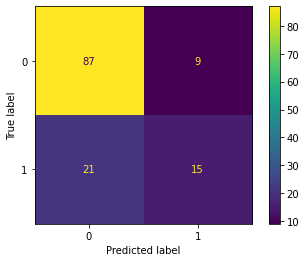

CPU times: user 46.9 s, sys: 447 ms, total: 47.3 s
Wall time: 47.4 s


In [44]:
%%time
#Random Forest
train_improve(df_improve , True)
#Takes  less than a minut

In [ ]:
%%time
#XGBoost
train_improve(df_improve , False)
#Takes one minut of time

# Conclusions

In the `first exercise`( [See the solution](#ex1)), I have prepared three different datasets in order to compute OASIS. The datasets are obtained using

 + All the instances of each feature(filtered on 24h) and the **modification** of OASIS (allowing NaN's).
 + All the instances of each feature(filtered on 48h) and the **original** of OASIS.
 + All the instances of each feature(filtered on 48h) and the **modification** of OASIS (allowing NaN's).
 
 
Once I have OASIS for every patient, I have trained a Random Forest classifier to predict if the Length of Stay is short (less than 4 days) or long (more than 4 days). The mean accuracy achieved in the 5-fold cross validation is 0.617, 0.390, 0.625 respectively. Notice that, in the second dataset, the one that NaN's are not allow to compute OASIS, we only have 53 rows of information, while in the others, we have 136 rows of information. As expected, the second, is the one with the worst performance. With regard to the others, we obtain a better accuracy in the third one, since we allow more data (samples of the first 48h are accepted instead of only 24h), although there is no significant improvement. Nevertheless, not only accuracy is important, but also confusion matrices are plotted in order to observe TP,TN,FN and FP, so we can compare each model in detail.

In the `second exercise`, I have computed and printed the required calculations. Go to the Exercise 2 to check the results. [Click to go](#ex2)

Finally, in the `third exercise` ([See the solution](#ex3)) I improved the prediction by learning from a multidimensional decision boundary considering more than one feature. It is important to remark that the features that I have selected have not been randomly chosen. The age, the preLOS, the admission type (dummies variables) and the ventilation have been added for each 'icustay_id' beacuse they are unic and informative for our goal (LOS). On the other hand, heart rate, temperature, respiratory rate, MAP and urine, although they are informative, they have multiple values for each 'icustay_id', since multiple measures were taken for all of them and, therefore, we were not able to choose one. We could think to choose the worst, but this is not a simple task. For instance, for the temperature, which is the worst value, the higher or the lower one? As you can see, it is not immediate and this is why I have decided to not adding them. Nevertheless, for the Glasgow Coma Scale(GCS), if we observe the doucumentation of the OASIS ([documentation](https://alistairewj.github.io/project/oasis/)), we can deduce that the lower the GCS is, the worse it is for the patient. Hence, we can add this feature to our improvement dataframe to train our classifier.

I have trained two different classifiers, a random forest and a xgboost, in which I perform hyperparameter tuning with the help of the function GridSearchCV. Notice that xgboost has a slightly higher performance than the random forest, reaching 0.781 in the xgboost and 0.774 in the random forest using the mean accuracy of the 5-fold cross validation. Again, you can compare the models in detail with the confusion matrix.